## 竞赛主题：Nano识图学说话-多模态AI会话式目标识别


### 实验环境:
  * **硬件平台**： NVIDIA Jetson NANO
  * **软件平台**： 
    1. NVIDIA Jetpack 4.4
    2. Ubuntu 18.04 L4T
    3. Python 3.6.9
    4. TensorRT 7.1
    5. CUDA 10.2
    6. Tensorflow 1.15
    7. NVIDIA TAO Toolkit
    8. Numpy 1.16.1
    9. Opencv 4.1.1
    10. Pytorch 1.8.0
    11. NeMo 1.2.0
    12. Numba 0.52.0

### 软件开发工具介绍:
#### 1 利用NVIDIA NeMo对话式AI工具库实现语音识别及语言合成

* 为了使活动更具丰富性，凸显语音语义与计算机视觉的结合应用，此处增加了NLP自然语言处理中的语音识别和语音合成的部分。
* 本次实验将通过语音识别的方式，分别识别出指令为：“请指出哪张序列号的图片是猫/狗/马/人"。检测出对应图片，并输出该图片对应的文字表述，通过语音合成技术将文字表述进行朗读。
* 本次实验会需要参赛队伍录制自己的语音数据，通过建立语音数据集，加载预训练模型、迁移学习方法、或从头训练方法训练语音识别及语音合成模型，完成NLP对话式AI应用中基本的语音识别及语言合成功能
* 本次课程提供最基础的开发流程，以及相关工具和框架的使用方法，鼓励各位开发者在本教程的基础上做更多更好的优化。

#### NeMo简介

* NeMo是一个多模态对话式AI工具包集成(ASR-NLP-TTS)以Pytorch/Pytorch Lightning为后端，可以实现分布式训练混合精度计算，便于微调和迁移学习任务、
* NeMo能够利用NVIDIA GPU上的Tensor Core核心，通过混合精度计算来获得最高性能。包括了将训练扩展到多GPU系统和多节点集群的功能
* NeMo使用户可以使用可重用的组件建立复杂的神经网络架构。利用神经类型，这些组件之间会自动进行语义兼容性检查

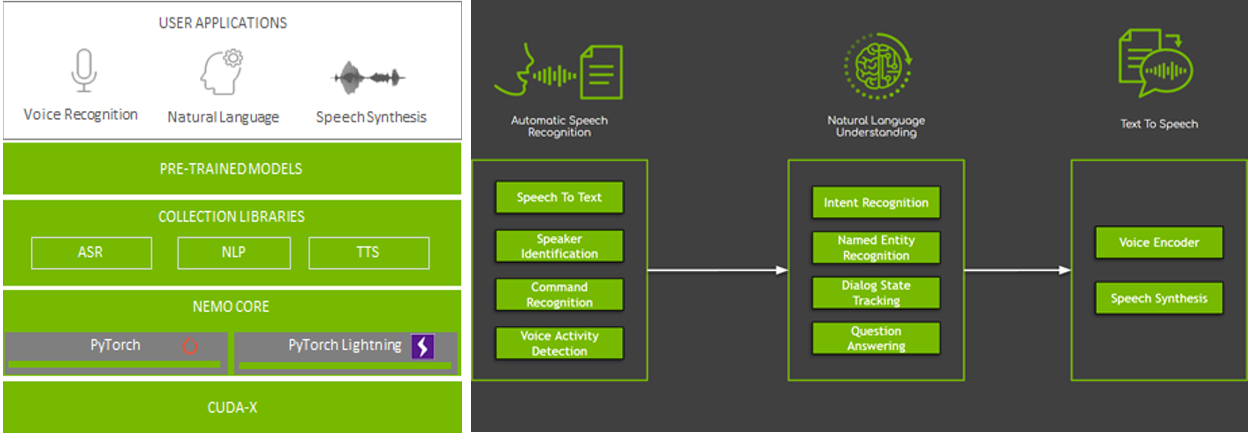


#### 2 利用NVIDIA TensorRT加速SSD-resnet18模型实现图像目标检测
* 本次课程利用NVIDIA TAO Toolkit训练模型，训练模型以及优化模型部分请参阅[TAO Toolkit 开发者文档](https://developer.nvidia.com/tao-toolkit-get-started)
* 本次课程针对有一定编程基础的开发者，需要对Python，深度学习，opencv等内容有一定了解
* 本次课程目标是利用NVIDIA TensorRT加速SSD-resnet18的目标检测模型，实现在图片中检测出目标，并判断是哪一类
* 本次实验将检测目标分为四类，分别是猫(cat),狗(dog),马(hourse)，人（person）
* 本次实验会提供基础的训练数据集，用于参赛队伍训练。但是，为了取得更好的成绩，需要对这个数据集需要进一步清理，扩展以及优化。
* 本次课程提供最基础的开发流程，以及相关工具和框架的使用方法，鼓励各位开发者在本教程的基础上做更多更好的优化。
    


#### TensorRT简介
* [NVIDIA TensorRT™](https://developer.nvidia.com/tensorrt)是一个用于高性能深度学习推理（inference）的SDK。它包括一个深度学习推理优化器和运行时加速库，为深度学习推理应用程序提供低延迟和高吞吐量。
* TensorRT现已能支持TensorFlow、Caffe、Mxnet、Pytorch等几乎所有的深度学习框架，将TensorRT和NVIDIA的GPU结合起来，能在几乎所有的框架中进行快速和高效的部署推理。
* TensorRT 是一个C++库，从 TensorRT 3 开始提供C++ API和Python API，主要用来针对 NVIDIA GPU进行 高性能推理（Inference）加速,现在最新版TensorRT 7.1。
* TensorRT 是专门用来做深度学习<font color=#008000 size=4>推理</font> 任务的,可以独立于训练框架使用。
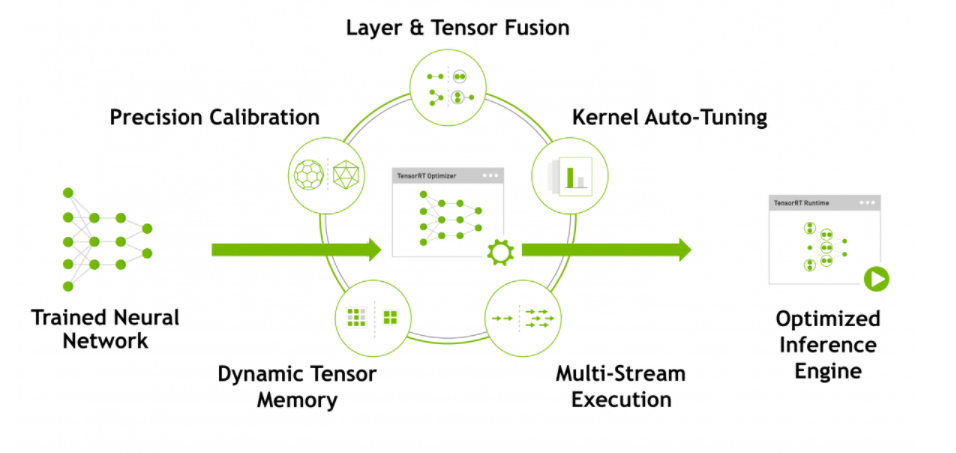

#### 实现流程描述：
##### 1 新建一个文件夹用来存放用于目标识别的图片：手动上传四张带有序列标记（数字形式的文件名）的图片
##### 2 使用录音工具录制语音指令如："请指出哪个序列号的图片是猫"，将这段语音作为语音识别部分的语音输入
##### 3 通过自动语音识别模块将"请指出哪个序列号的图片是猫"这段语音转录成"请指出哪个序列号的图片是猫"的文字
##### 4 "请指出哪个序列号的图片是猫"作为图像模块目标识别的文字输入指令
##### 5 图像识别模块会根据关键字"猫"为根据进行图像识别
##### 6 图像识别模块会在存放图片的目录中寻找出猫的图片，同时检测出猫在图片中的位置,并输出"猫图片的序列号是1" 的文字描述
##### 7 语音合成模块利用训练好的模型将"猫图片的序列号是1" 的文字进行语音合成并输出对应的语音，即将"猫图片的序列号是1"用声音说出来

====================================================================================

### #0 导入相关工具库

In [1]:
import numba
import nemo
import os
import re
import IPython
import soundfile as sf
import nemo.collections.asr as nemo_asr
import nemo.collections.tts as nemo_tts
from nemo.collections.asr.models import EncDecCTCModel
from nemo.collections.tts.models import Tacotron2Model
from nemo.collections.tts.models import MelGanModel
from ASR_metrics import utils as metrics
from matplotlib.pyplot import imshow
from matplotlib import pyplot as plt
from IPython.display import Image

[NeMo W 2021-11-28 15:27:28 optimizers:47] Apex was not found. Using the lamb optimizer will error out.


BadZipFile: File is not a zip file

### #1 语音识别模块
##### #1.1 加载ASR自动语音识别模型
```Python
asr_model = EncDecCTCModel.restore_from("/home/nvidia/speech_model/stt_zh_quartznet15x5.nemo").cuda() #从本地加载预训练模型
asr_model = EncDecCTCModel.restore_from("/home/nvidia/speech_model/asr_model.nemo").cuda() #从本地加载服务器端训练好的语音识别模型


##### #1.2 调用ASR自动语音识别模型的transcribe函数实现：语音=>文字的转录
```Python
#将用于识别的语音传入，用模型的transcribe函数进行识别（注意音频路径）
asr_result = asr_model.transcribe(paths2audio_files = ["/home/nvidia/asr_audio/cat_e.wav"])
```

##### 下面的步骤会将语音转化成文字： 音频文件 ==> 识别命令
asr_result为语音识别结果，它将作为下一步图像识别的命令, 其中检测出 "猫"/"狗"/"马"/"人" 这些类别的关键字是进行下一步图像识别的关键前提

##### 为了避免内存的资源占用，我们采用子进程的方式将语音识别部分的代码封装至audio_to_txt.py脚本中

In [ ]:
asr_result = !python3 audio_to_txt.py #由于nano边缘设备的内存限制，本步骤执行需要大约3分钟拿到识别结果）
asr_result = (asr_result[-1])
print(asr_result)

##### #1.3 对语音识别结果进行CER字错率的评估

In [ ]:
s1 = "请指出哪个序列号的图片是猫"#指定正确答案
s2 = " ".join(asr_result)#识别结果
print("字错率:{}".format(metrics.calculate_cer(s1,s2)))#计算字错率cer
print("准确率:{}".format(1-metrics.calculate_cer(s1,s2)))#计算准确率accuracy

=====================================================================================

### #2 计算机视觉图像识别模块

##### #2.1将语音识别的结果作为图像识别的指令

In [ ]:
asr_result = "请指出哪个序列号的图片是猫"

In [ ]:
cls_list = ['bg', '猫', '狗', '马', '人']
contrast_dict_ASR = {"猫": "cat", "狗": "dog", "马": "horse", "人": "person"}
singl_clss_word = contrast_dict_ASR[str(asr_result[-1])]  #要检测的类别名字
keyword = cls_list.index(asr_result[-1])  #要检测的类别名字
print(singl_clss_word)

In [ ]:
! python3 ./Hackathon_CV/yolov5_detect.py \
        --detectmode "clss_detect"  \
        --plugin /home/nvidia/asr_final_audio/libmyplugins.so  \
        --engine /home/nvidia/asr_final_audio/yolo.engine  \
        --imgdir ./Hackathon_CV/val/images/ \
        --imgoutdir ./Hackathon_CV/val/img_output_dir/ \
        --labeloutdir ./Hackathon_CV/val/label_output_dir/  \
        --imwrite True \
        --conf 0.4 \
        --singl_clss_detect  $singl_clss_word

In [ ]:
from IPython.display import Image
imgNameList = os.listdir("./Hackathon_CV/val/label_output_dir")
# print(imgNumList)

#调用Detection.find_imgName_from_dir函数，该函数将对实验图片文件夹内的所有图片进行检测，并将检测到的结果返回
# imgNameList = Detection.find_imgName_from_dir(dirName, keyword, resultDir) #imgNameList为检测到目标的图片名字列表
imgNumList = []
for imgName in imgNameList:
#     print("检测到"+cls_list[keyword]+"的图片列表为： \n"+str(imgName))
    imgNumList.append(imgName.split('.')[0]) 

text_to_nemo = cls_list[keyword]+"图片的序列号是"+imgNumList[0]
print(text_to_nemo)
img_name = "./Hackathon_CV/val/img_output_dir/" + imgNumList[1] + '.jpg'
Image(img_name)

In [ ]:
! python3 ./Hackathon_CV/yolov5_detect.py \
        --detectmode "detect_dir"  \
        --plugin /home/nvidia/asr_final_audio//libmyplugins.so  \
        --engine /home/nvidia/asr_final_audio/yolo.engine  \
        --imgdir ~/Hackathon_CV/val/images/ \
        --imgoutdir ./Hackathon_CV/val/img_output_dir/ \
        --labeloutdir ~/Hackathon_CV/mAP/input/detection-results/  \
        --imwrite True \
        --conf 0.1

=====================================================================================

###  #3 语音合成模块
##### #3.1 加载Tacotron2声学模型

In [ ]:
spec_generator = Tacotron2Model.restore_from("/home/nvidia/asr_final_audio/Tacotron2.nemo")#在本地将服务器端训练好的TTS模型进行导入

##### #3.2 加载Melgan声码器模型

In [ ]:
# 加载声码器模型
model = MelGanModel.restore_from("/home/nvidia/speech_model/tts_melgan.nemo")

##### #3.3 通过声学模型tacotron2用于生成文字对应的频谱图，该频谱图将用于合成语音结果

In [ ]:
text_to_nemo = "猫图片的序列号是1"

In [ ]:
%matplotlib inline
parsed = spec_generator.parse(text_to_nemo)#调用parse函数获取文本的数字化
spectrogram = spec_generator.generate_spectrogram(tokens=parsed)#调用模型的generate_spectrogram函数生成频谱图
imshow(spectrogram.cpu().detach().numpy()[0,...], origin="lower")#将Tensor转换为numpy array进行可视化
plt.show() #matplotlib展示文字对应的频谱图

##### #3.4 通过melgan声码器合成音频：将频谱图=>音频文件，并播放

In [ ]:
audio = model.convert_spectrogram_to_audio(spec=spectrogram) #调用模型convert_spectrogram_to_audio()函数进行频谱到音频文件的转换
IPython.display.Audio(audio.to('cpu').detach().numpy(), rate=22050)

##### #3.5 将合成出来的音频写入磁盘

In [ ]:
import scipy.io.wavfile as wavf
audio=audio.to('cpu').detach().numpy()
wavf.write('out.wav', 22050, audio.T)

##### #3.6 对合成出来的音频与原始音频进行对比测评,对比的语音内容要求一致。

In [ ]:
from pesq import pesq
#pesq为客观音频可懂性评价标准
rate,ref = wavf.read("/home/nvidia/gt_audio/m_cat.wav")#读取groud truth原始音频
rate, deg = wavf.read("out.wav")#读取合成音频
print(pesq(16000, ref, deg, 'wb')) #pesq只支持8000和16000Hz的音频评估

=====================================================================================

#### 评分标准
本次比赛最终成绩由以下五部分组成：

* 1.语音识别部分推理精度（accASR）：将最终提交的模型在NANO节点上进行推理，根据组委会提供的测试语音进行推理并计算字错率(cer_score)的分数，进而得到准确率的分数即（accASR = 1 -cer_score）

* 2.计算机视觉部分推理精度：将最终提交的模型在NANO节点上进行推理，根据组委会提供的测试数据集进行推理并计算mAP精度部分的最终成绩为:  accCV= 60-(accRank-1)

* 3.语音合成pesq客观语音质量评估分数：计算两个音频的pesq，PESQ就是用经过处理后的语音文件（语音压缩、合成、重构等）与原始目标语音进行比较。PESQ得分范围在-0.5--4.5之间。得分越高表示语音质量越好。

* 4.语音合成MOS音频主观可懂性分数：采取5个级别对被测语音的质量进行评价。待测语音的质量是在所有试听人员的评分上求平均得到的。这种方式被称作主观平均意见得分（Mean Opinion Score, MOS）
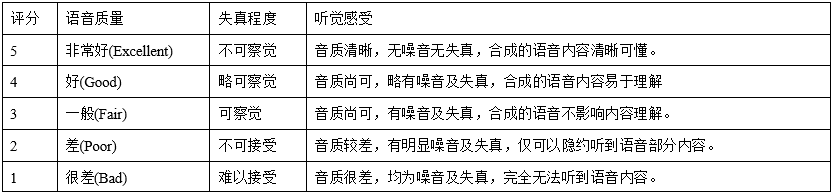

* 5 网络模型重构（5%）：本教程语音识别部分提供的是Quartznet的预训练模型，如果能够自制语音数据集并利用迁移学习的方法进行模型训练并完成推理，则最终成绩isOthermodel加5分，视觉部分（修改resnet18加3分，修改ssd加5分，如：利用ssd-mobilenet则加3分，利用yolo-resnet18加5分）


最终成绩为五部分分数之和：Final = accASR + accCV + pesqTTS + mosTTS + isOthermodel 
分数最高者为胜出团队。
